In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nx = 4
nu = 2
T = 50
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(5, 5, 2, 'Obs0')
obs1 = Obstacle(3.5, 3.5, 1, 'Obs1')
obs2 = Obstacle(6.5, 6.5, 1, 'Obs2')
obs3 = Obstacle(6.5, 3.5, 1, 'Obs3')
obs_set = [obs1, obs2, obs3]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [3]:
# Desired Running and Terminal Model
w_run = np.array([10, .1, .1, 200, 150, 100])
w_term = np.array([1000, .1, .1, 100, 150, 200])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.02500e+02  1.02500e+02  3.30585e+01  1.0000  0.00000e+00  9.97786e+00
   2  1.32882e+00  1.32882e+00  7.22396e-02  1.0000  2.66454e-14  1.19346e-02
   3  1.32788e+00  1.32788e+00  5.90206e-02  1.0000  1.21610e-10  3.78072e-03
   4  1.32728e+00  1.32728e+00  5.64197e-02  1.0000  1.31721e-10  3.27329e-03
   5  1.32671e+00  1.32671e+00  6.16750e-02  1.0000  1.41940e-10  5.24767e-03
   6  1.32605e+00  1.32605e+00  7.50259e-02  1.0000  1.29700e-10  7.95949e-03
   7  1.32515e+00  1.32515e+00  9.72862e-02  1.0000  1.42212e-10  1.08651e-02
   8  1.32375e+00  1.32375e+00  1.23446e-01  1.0000  2.01823e-10  1.24229e-02
   9  1.32158e+00  1.32158e+00  1.44512e-01  1.0000  2.46453e-10  1.15612e-02
  10  1.31858e+00  1.31858e+00  1.57837e-01  1.0000  3.07688e-10  9.16097e-03
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.31489e+00  1.31489e+00  1.02281e+01  1.0000  3.59199e-10  6.1992

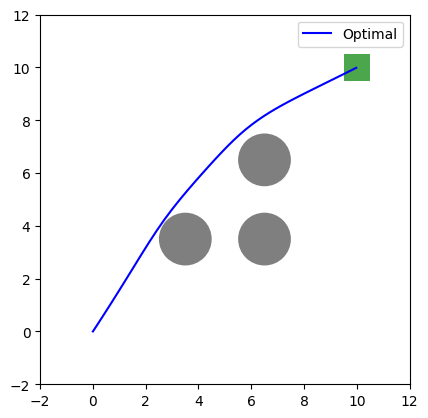

In [4]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(xs_optimal, obs_set, target_high, label='Optimal', linemap = 'b')

In [43]:
# Generating bad set of weights
w_bads = []
num_bad = 10
for i in range(num_bad):
    bad_weight_count = range(nr,len(w_des))
    bads = random.choice(bad_weight_count)
    w_0 = random.choices(range(len(w_des)), np.ones_like(w_des), k=bads)
    w_dummy = w_des.copy()
    # w_dummy[w_0] = np.random.uniform(0.0, 1.0, len(w_0))
    w_dummy[w_0] = 0.0
    w_dummy /= np.max(w_dummy)
    w_bads.append(w_dummy)

In [44]:
# Non-Optimal Demo Collection
xs_non_optimal_set = []
us_non_optimal_set = []
for w_i, w_bad in enumerate(w_bads):
    # w_bad /= np.max(w_bad)
    w_run = w_bad[:nr]
    w_term = w_bad[nr:]
    PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
    PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
    pmDataRunning = PM_DAM_running.createData()
    pmDataTerminal = PM_DAM_terminal.createData()
    PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
    PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
    timeStep = 5e-2
    PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
    PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
    x0 = np.array([0.0, 0.0, 0.0, 0.0])
    u0 = np.array([0.0, 0.0])
    problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
    # Creating the SQP solver
    sqp_non_opt = mim_solvers.SolverSQP(problem)
    sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
    sqp_non_opt.with_callbacks=False
    sqp_non_opt.termination_tolerance = 1e-5
    xs_init = [x0 for i in range(T+1)]
    us_init = [u0 for i in range(T)]
    
    # Solving this problem
    done = sqp_non_opt.solve(xs_init, us_init, 500)
    xs_non_optimal_set.append(np.stack(sqp_non_opt.xs.tolist().copy()))
    us_non_optimal_set.append(np.stack(sqp_non_opt.us.tolist().copy()))
    print('{}\'th non-optimal collected: {}'.format(w_i+1, done))


1'th non-optimal collected: True
2'th non-optimal collected: True
3'th non-optimal collected: True
4'th non-optimal collected: True
5'th non-optimal collected: True
6'th non-optimal collected: True
7'th non-optimal collected: True
8'th non-optimal collected: True
9'th non-optimal collected: True
10'th non-optimal collected: True


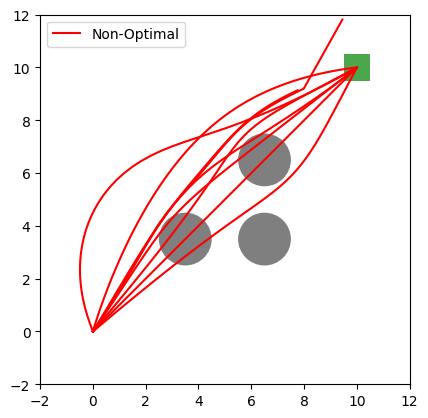

In [45]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
plot_1_set(xs_non_optimal_set, obs_set, target_high, label='Non-Optimal', linemap_traj = 'r', linemap_set = 'r')

In [46]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [54]:
dt = timeStep
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 100, 'iprint': 1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
x0 = random.choice(w_bads)
# x0 = w_des
res_1D = minimize(fcn_w, 
               x0, 
               args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)

print(res_1D)
w_irl = res_1D.x

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         6 variables are exactly at the bounds

At iterate    0    f=  2.10601D+00    |proj g|=  4.62324D+00

At iterate    1    f=  1.30894D+00    |proj g|=  1.60086D-01

At iterate    2    f=  1.30082D+00    |proj g|=  1.52395D-01

At iterate    3    f=  1.19484D+00    |proj g|=  1.01836D-01

At iterate    4    f=  1.12112D+00    |proj g|=  4.04190D-01

At iterate    5    f=  1.08541D+00    |proj g|=  7.74284D-01

At iterate    6    f=  9.91169D-01    |proj g|=  4.05567D-01

At iterate    7    f=  6.66944D-01    |proj g|=  1.99516D-01

At iterate    8    f=  2.37536D-01    |proj g|=  1.03418D-01

At iterate    9    f=  1.06589D-01    |proj g|=  4.96074D-02

At iterate   10    f=  5.06900D-02    |proj g|=  2.41429D-02

At iterate   11    f=  2.48821D-02    |proj g|=  1.19129D-02

At iterate   12    f=  1.23427D-02    |proj g|=  5.88319D-03

At iterate   13    f=  6.1

In [55]:
# w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.01 IRL:  10.79068509893577
Terminal ||  Desired:  1.0 IRL:  29.51965812649963

XReg :
Running ||  Desired:  0.0001 IRL:  0.0
Terminal ||  Desired:  0.0001 IRL:  0.9006389914026266

UReg :
Running ||  Desired:  0.0001 IRL:  5.673340266828729
Terminal ||  Desired:  0.0001 IRL:  0.0001

Obs1 :
Running ||  Desired:  0.2 IRL:  34.51082504369798
Terminal ||  Desired:  0.1 IRL:  0.14220358998735397

Obs2 :
Running ||  Desired:  0.15 IRL:  67.47121227134598
Terminal ||  Desired:  0.15 IRL:  0.0

Obs3 :
Running ||  Desired:  0.1 IRL:  54.669854813554224
Terminal ||  Desired:  0.2 IRL:  0.3557272336473943



In [56]:
print('Desired: ')
print('Running ==>    ', w_des[:nr])
print('Terminal ==>   ', w_des[nr:])
print('IRL: ')
print('Running ==>    ', w_irl[:nr])
print('Terminal ==>   ', w_irl[nr:])

Desired: 
Running ==>     [1.0e-02 1.0e-04 1.0e-04 2.0e-01 1.5e-01 1.0e-01]
Terminal ==>    [1.0e+00 1.0e-04 1.0e-04 1.0e-01 1.5e-01 2.0e-01]
IRL: 
Running ==>     [10.7906851   0.          5.67334027 34.51082504 67.47121227 54.66985481]
Terminal ==>    [2.95196581e+01 9.00638991e-01 1.00000000e-04 1.42203590e-01
 0.00000000e+00 3.55727234e-01]


In [57]:
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
# print('Bad Trajectory Cost:     ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, x0[:nr], x0[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_irl[:nr], w_irl[nr:], timeStep))

Desired Trajectory Cost:  0.3855149732466823  || with IRL Weight:   412.1009335758978


In [58]:
# Test IRL 1D Output
print('Desired Fcn:    ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL Fcn:     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
# print('Bad Fcn:        ', fcn_w(x0, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     2.0373384450169345
IRL Fcn:      5.437302831680597e-10


In [59]:
# Run again with bad weights (zero for obstacles)
w_run = w_irl[:nr]
w_term = w_irl[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]
# xs_init = [xs_optimal[i] for i in range(T+1)]
# us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  5.64965e+03  5.64965e+03  2.34424e+01  1.0000  0.00000e+00  2.64385e+02
   2  1.90748e+03  1.90748e+03  2.79626e-03  1.0000  2.80609e-14  1.53308e+00
   3  1.90747e+03  1.90747e+03  2.96571e-03  1.0000  5.27305e-12  1.96508e+00
   4  1.90746e+03  1.90746e+03  3.43716e-03  1.0000  3.95735e-12  2.46145e+00
   5  1.90744e+03  1.90744e+03  4.29389e-03  1.0000  5.28592e-12  2.95873e+00
   6  1.90742e+03  1.90742e+03  5.24157e-03  1.0000  5.49761e-12  3.37489e+00
   7  1.90738e+03  1.90738e+03  6.18955e-03  1.0000  5.77551e-12  3.64811e+00
   8  1.90734e+03  1.90734e+03  7.08023e-03  1.0000  7.39879e-12  3.74066e+00
   9  1.90728e+03  1.90728e+03  7.87706e-03  1.0000  7.99800e-12  3.61460e+00
  10  1.90720e+03  1.90720e+03  8.55405e-03  1.0000  9.82638e-12  3.25545e+00
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.90711e+03  1.90711e+03  9.06713e-03  1.0000  9.71310e-12  2.7212

485.51964690859836


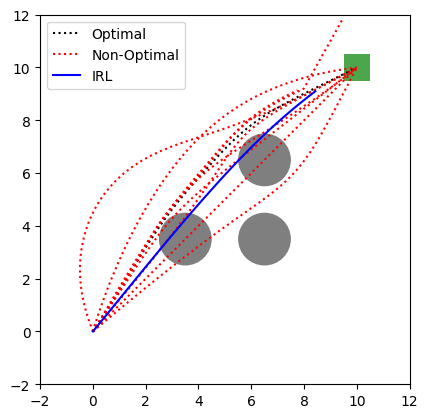

In [60]:
print(cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], dt))
plot_results(xs_optimal, xs_non_optimal_set, xs_output, obs_set, target_high)